In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import nltk


# **Text Preprocessing**

In [2]:
data_dir = "data"
file_path = data_dir + "/en_US.twitter.txt"

## nltk settings
nltk.data.path.append(data_dir)
nltk.download('punkt')

with open(file_path, "r", encoding='utf-8') as f:
    data = f.read()   


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
type(data)

str

In [9]:
len(data)

500000

In [7]:
data[:10]

'How are yo'

In [8]:
data = data[:500000]

In [10]:
import re
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile(
      "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
       "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text


In [11]:
def preprocess_pipeline(data) -> 'list':

    # Split by newline character
    sentences = data.split('\n')
    for i  in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop Empty Sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Empty List to hold Tokenized Sentences
    tokenized = []
    
    # Iterate through sentences
    for sentence in sentences:
        
        # Convert to lowercase
        sentence = sentence.lower()
        
        # Convert to a list of words
        
        # Append to list
        tokenized.append(sentence)
        
    return tokenized

In [12]:
tokenized_sentences = preprocess_pipeline(data)



In [13]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1


In [20]:
total_words

13175

In [14]:
print(len(tokenized_sentences))

7216


In [16]:
tokenizer.texts_to_sequences([tokenized_sentences[0]])[0]

[55,
 25,
 6,
 1013,
 44,
 8,
 2,
 49,
 6,
 173,
 17,
 9,
 722,
 689,
 166,
 38,
 3,
 69,
 6,
 98,
 120,
 120,
 89,
 235]

In [17]:
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [18]:
print(len(input_sequences))

83036


pad sequence

In [19]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen = max_sequence_len,
                                        padding='pre'))
len(input_sequences[1])

34

prepare feature and labels

In [21]:
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Model

In [24]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X, ys, epochs=30, verbose=1)
#print model.summary() 
print(model)


c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
 451/2595 ━━━━━━━━━━━━━━━━━━━━ 2:07 59ms/step - accuracy: 0.0283 - loss: 7.8073

KeyboardInterrupt: 

In [14]:
model.save('my_model1.keras')


In [15]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    

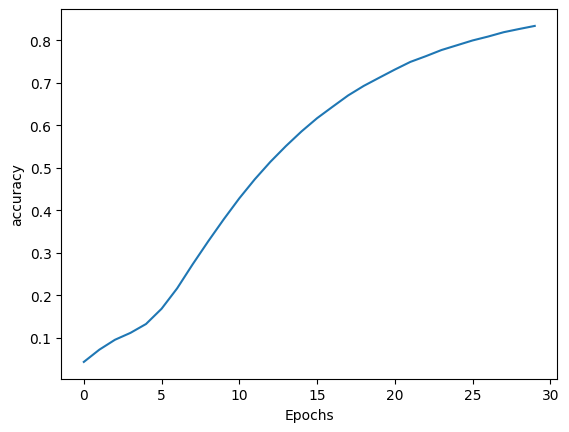

In [16]:
plot_graphs(history, 'accuracy')


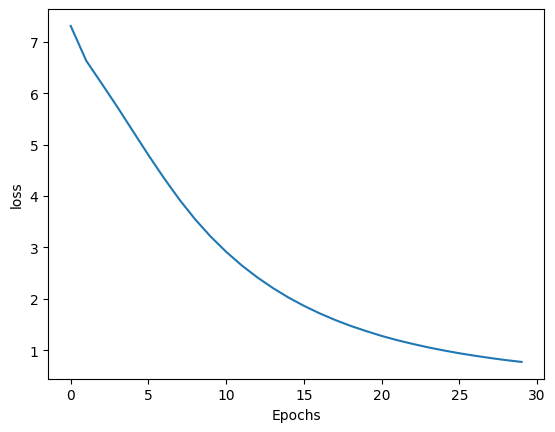

In [17]:
plot_graphs(history, 'loss')


In [25]:
seed_text = "Lets"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)


Lets go puppies
